<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="../../docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [5]:
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import glob
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import os
os.path.isfile('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918')
import sys
import time
import cv2
try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        print((1))
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    print('Not IPYTHON')
    pass

import caiman as cm
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf.utilities import detrend_df_f
from caiman.components_evaluation import estimate_components_quality_auto
import bokeh.plotting as bpl
bpl.output_notebook()

1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

### Setup some parameters

In [6]:
# dataset dependent parameters
fname = ['/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T1_G.tiff',
         '/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T6_G.tiff'
         ]  

# filename to be processed
fr = 4                             # imaging rate in frames per second
decay_time = 0.4                    # length of a typical transient in seconds

# motion correction parameters
niter_rig = 1               # number of iterations for rigid motion correction
max_shifts = (6, 6)         # maximum allow rigid shift
splits_rig = 2          # for parallelization split the movies in  num_splits chuncks across time
strides = (48, 48)          # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)         # overlap between pathes (size of patch strides+overlaps)
splits_els = 2         # for parallelization split the movies in  num_splits chuncks across time
upsample_factor_grid = 4    # upsample factor to avoid smearing when merging patches
max_deviation_rigid = 3     # maximum deviation allowed for patch with respect to rigid shifts

# parameters for source extraction and deconvolution
p = 1                       # order of the autoregressive system
gnb = 2                     # number of global background components
merge_thresh = 0.8          # merging threshold, max correlation allowed
rf = 15                     # half-size of the patches in pixels. e.g., if rf=25, patches are 50x50
stride_cnmf = 6             # amount of overlap between the patches in pixels
K = 4                       # number of components per patch
gSig = [4, 4]               # expected half size of neurons
init_method = 'greedy_roi'  # initialization method (if analyzing dendritic data using 'sparse_nmf')
is_dendrites = False        # flag for analyzing dendritic data
alpha_snmf = None           # sparsity penalty for dendritic data analysis through sparse NMF

# parameters for component evaluation
min_SNR = 2.5               # signal to noise ratio for accepting a component
rval_thr = 0.8              # space correlation threshold for accepting a component
cnn_thr = 0.8               # threshold for CNN based classifier

Download the dataset if not already present

In [7]:
if fname[0] in ['Sue_2x_3000_40_-46.tif','demoMovie.tif']:
    fname = [download_demo(fname[0])]

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel.

In [8]:
m_orig = cm.load_movie_chain(fname[:2])
downsample_ratio = 0.2
offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
m_orig.resize(1, 1, downsample_ratio).play(
gain=10, offset=offset_mov, fr=4, magnification=2)

100%|██████████| 2/2 [00:00<00:00,  8.11it/s]


reshaping along z


##### Setup a cluster

In [9]:
#%% start a cluster for parallel processing
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

0
0
10
10
20
20
30
30
40
40
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


50
0
0
10
10
20
20
30
30
40
40
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0
0
0
0
0
0


/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  return a / b
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/past/utils/__init__.py:95: RuntimeWarning: invalid value encountered in true_divide
  retur

10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
30
40
40
40
40
40
40
50
50
50
50
50
50


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


0


/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
/home/murthyhacker/CaImAn/caiman/motion_correction.py:2457: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50
0
0
0
0
0
0
10
10
10
10
10
10
20
20
20
20
20
20
30
30
30
30
30
30
40
40
40
40
40
40
50
50
50
50
50
50
0
10
20
30
40
50
0
0
10
10
20
20
30
30
40
40
50
50


## Motion Correction
First we create a motion correction object with the parameters specified. Note that the file is not loaded in memory

In [10]:
# first we create a motion correction object with the parameters specified
min_mov = min(cm.load(fname[0], subindices=slice(200)).min(),0) 
        # this will be subtracted from the movie to make it non-negative 

mc = MotionCorrect(fname[:2], min_mov,
                   dview=dview, max_shifts=max_shifts, niter_rig=niter_rig,
                   splits_rig=splits_rig, 
                   strides= strides, overlaps= overlaps, splits_els=splits_els,
                   upsample_factor_grid=upsample_factor_grid,
                   max_deviation_rigid=max_deviation_rigid, 
                   shifts_opencv = True, nonneg_movie = True)
# note that the file is not loaded in memory

Now perform motion correction. From the movie above we see that the dateset exhibits non-uniform motion. We will perform piecewise rigid motion correction using the NoRMCorre algorithm.

In [11]:
%%capture
#%% Run piecewise-rigid motion correction using NoRMCorre
mc.motion_correct_pwrigid(save_movie=True)
m_els = cm.load(mc.fname_tot_els)
bord_px_els = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                 np.max(np.abs(mc.y_shifts_els)))).astype(np.int)  
    # maximum shift to be used for trimming against NaNs

Inspect the results by comparing the original movie. A more detailed presentation of the motion correction method can be found in the [demo motion correction](./demo_motion_correction.ipynb) notebook.

In [12]:
#%% compare with original movie
cm.concatenate([m_orig.resize(1, 1, downsample_ratio)+offset_mov,
                m_els.resize(1, 1, downsample_ratio)], 
               axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit

reshaping along z
reshaping along z


## Memory mapping 

The cell below memory maps the file in order `C` and then loads the new memory mapped file.

In [13]:
#%% MEMORY MAPPING
# memory map the file in order 'C'
fnames = mc.fname_tot_els   # name of the pw-rigidly corrected file.
border_to_0 = bord_px_els     # number of pixels to exclude
fname_new = cm.save_memmap(fnames, base_name='memmap_', order = 'C',
                           border_to_0 = bord_px_els) # exclude borders

# now load the file
Yr, dims, T = cm.load_memmap(fname_new)
d1, d2 = dims
images = np.reshape(Yr.T, [T] + list(dims), order='F') 
    #load frames in python format (T x X x Y)

RECOMPUTING EACH FILE MEMORY MAP
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T1_G._els__d1_301_d2_300_d3_1_order_F_frames_108_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/071918_f1_T6_G._els__d1_301_d2_300_d3_1_order_F_frames_109_.mmap
loading in memory
mmap
SAVING WITH numpy.tofile()
('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap', 108)
('/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap', 109)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap__d1_301_d2_300_d3_1_order_C_frames_217_.mmap
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_

(27090, 27993)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(27993, 28896)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(28896, 29799)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(29799, 30702)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Des

done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(61404, 62307)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(62307, 63210)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0001_d1_301_d2_300_d3_1_order_C_frames_109_.mmap
(63210, 64113)
done
(903, 217)
/home/murthyhacker/Desktop/Rachele/datasetJ/cell_bodies/071918/f1/memmap_0000_d1_301_d2_300_d3_1_order_C_frames_108_.mmap
/home/murthyhacker/Desktop/Rachele/da

Now restart the cluster to clean up the memory

In [14]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

(217, 31, 31)
(217, 31, 31)
(217, 31, 31)
(217, 31, 31)
(217, 31, 31)
using 1 processes
using 1 processes
using 1 processes
using 1 processes
using 1 processes
using 225 pixels per process
(217, 31, 31)
using 225 pixels per process
using 225 pixels per process
using 225 pixels per process
using 5000 block_size
using 225 pixels per process
using 5000 block_size
using 5000 block_size
using 5000 block_size
using 1 processes
preprocessing ...
preprocessing ...
using 5000 block_size
checking if missing data
checking if missing data
preprocessing ...
preprocessing ...
preprocessing ...
checking if missing data
checking if missing data
using 225 pixels per process
using 5000 block_size
checking if missing data
preprocessing ...
checking if missing data
initializing ...
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
Noise Normalization
initializing ...
reshaping along x and y
Noise Normalization
(108, 15)
initializing ...
Spatial Downsampling 2-photon
Noise Normalization
Sp

(Hals) Refining Components...
using 5000 block_size
using 5000 block_size
preprocessing ...
checking if missing data
preprocessing ...
(217, 31, 31)
preprocessing ...
checking if missing data
checking if missing data
using 1 processes
using 225 pixels per process
using 5000 block_size
False
preprocessing ...
checking if missing data
False
(217, 31, 31)
using 1 processes
using 225 pixels per process
(217, 31, 31)
using 5000 block_size
using 1 processes
initializing ...
using 225 pixels per process
preprocessing ...
initializing ...
checking if missing data
using 5000 block_size
Noise Normalization
Noise Normalization
Spatial Downsampling 2-photon
preprocessing ...
Spatial Downsampling 2-photon
reshaping along x and y
initializing ...
checking if missing data
(108, 15)
Noise Normalization
initializing ...
reshaping along x and y
Noise Normalization
Spatial Downsampling 2-photon
reshaping along z
reshaping along x and y
(108, 15)
***** OPENCV!!!!
Spatial Downsampling 2-photon
reshaping al

using 5000 block_size
using 1 processes
using 225 pixels per process
using 225 pixels per process
(217, 31, 31)
using 5000 block_size
using 5000 block_size
preprocessing ...
preprocessing ...
checking if missing data
checking if missing data
initializing ...
preprocessing ...
preprocessing ...
checking if missing data
using 1 processes
checking if missing data
Noise Normalization
Spatial Downsampling 2-photon
using 225 pixels per process
using 5000 block_size
reshaping along x and y
preprocessing ...
(108, 15)
checking if missing data
initializing ...
reshaping along z
***** OPENCV!!!!
Roi Extraction...
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
initializing ...
Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along x and y
initializing ...
USING ROLLING SUM FOR INITIALIZATION....
(108, 15)
Noise Normalization
Spatial Downsamplin

preprocessing ...
USING ROLLING SUM FOR INITIALIZATION....
checking if missing data
(Hals) Refining Components...
(Hals) Refining Components...
(Hals) Refining Components...
(Hals) Refining Components...
initializing ...
False
Noise Normalization
initializing ...
False
Spatial Downsampling 2-photon
Noise Normalization
(217, 31, 31)
reshaping along x and y
(217, 31, 31)
using 1 processes
Spatial Downsampling 2-photon
using 225 pixels per process
False
reshaping along x and y
False
using 1 processes
(108, 15)
using 5000 block_size
reshaping along z
using 225 pixels per process
(108, 15)
reshaping along z
***** OPENCV!!!!
Roi Extraction...
(217, 31, 31)
(217, 31, 31)
using 5000 block_size
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
***** OPENCV!!!!
preprocessing ...
preprocessing ...
using 1 processes
using 225 pixels per process
using 5000 block_size
USING ROLLING SUM FOR INITIALIZATION....
using 1 processes
preprocessing ...
checking if miss

using 1 processes
using 225 pixels per process
preprocessing ...
using 225 pixels per process
***** OPENCV!!!!
checking if missing data
using 5000 block_size
preprocessing ...
initializing ...
using 5000 block_size
Noise Normalization
checking if missing data
Spatial Downsampling 2-photon
reshaping along x and y
Roi Extraction...
(108, 15)
initializing ...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
preprocessing ...
Noise Normalization
reshaping along z
USING ROLLING SUM FOR INITIALIZATION....
checking if missing data
***** OPENCV!!!!
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Spatial Downsampling 2-photon
reshaping along x and y
initializing ...
Noise Normalization
initializing ...
USING ROLLING SUM FOR INITIALIZATION....
Spatial Downsampling 2-photon
Noise Normalization
reshaping along x and y
(108, 15)
initializing ...
Spatial Downsampling 2-photon
(108, 15)
reshaping alon

Noise Normalization
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
initializing ...
Noise Normalization
reshaping along z
initializing ...
Spatial Downsampling 2-photon
reshaping along x and y
Noise Normalization
***** OPENCV!!!!
initializing ...
Roi Extraction...
initializing ...
Noise Normalization
(108, 15)
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Noise Normalization
Spatial Downsampling 2-photon
Spatial Downsampling 2-photon
reshaping along x and y
initializing ...
USING ROLLING SUM FOR INITIALIZATION....
reshaping along x and y
(108, 15)
reshaping along z
Spatial Downsampling 2-photon
reshaping along z
reshaping along x and y
***** OPENCV!!!!
(108, 15)
Noise Normalization
reshaping along z
Roi Extraction...
***** OPENCV!!!!
Roi Extraction...
***** OPENCV!!!!
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Spatial Downsampling 2-photon
Greedy initialization of spatial and tem

***** OPENCV!!!!
***** OPENCV!!!!
reshaping along z
Roi Extraction...
***** OPENCV!!!!
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Roi Extraction...
initializing ...
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
Noise Normalization
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
USING ROLLING SUM FOR INITIALIZATION....
USING ROLLING SUM FOR INITIALIZATION....
(Hals) Refining Components...
Spatial Downsampling 2-photon
reshaping along x and y
(108, 15)
reshaping along z
USING ROLLING SUM FOR INITIALIZATION....
***** OPENCV!!!!
(Hals) Refining Components...
Roi Extraction...
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
False
USING ROLLING SUM FOR INITIALIZATION....
False
(217, 31, 31)
using 1 processes
(217, 30, 31)
using 225 pixels per process
using 1 processes
using 5000 block_size
using 225 pi

using 1 processes
using 225 pixels per process
Spatial Downsampling 2-photon
using 225 pixels per process
reshaping along x and y
(108, 15)
using 5000 block_size
using 5000 block_size
reshaping along x and y
initializing ...
preprocessing ...
(108, 15)
preprocessing ...
reshaping along z
checking if missing data
Noise Normalization
checking if missing data
***** OPENCV!!!!
Spatial Downsampling 2-photon
reshaping along z
Roi Extraction...
initializing ...
Noise Normalization
reshaping along x and y
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
***** OPENCV!!!!
Spatial Downsampling 2-photon
(108, 15)
USING ROLLING SUM FOR INITIALIZATION....
Roi Extraction...
reshaping along x and y
(108, 15)
Greedy initialization of spatial and temporal components using spatial Gaussian filtering
reshaping along z
reshaping along z
***** OPENCV!!!!
USING ROLLING SUM FOR INITIALIZATION....
Roi Extraction...
***** OPENCV!!!!
Greedy initialization of spatial and t

/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 217, using nperseg = 217
  .format(nperseg, input_length))
/home/murthyhacker/anaconda3/envs/caiman/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 i

tB:-2.0,tA:5.0
Computing event exceptionality delta
tB:-2.0,tA:5.0
Computing event exceptionality delta
tB:-2.0,tA:5.0
tB:-2.0,tA:5.0
Removing Baseline
tB:-2.0,tA:5.0
Removing Baseline
tB:-2.0,tA:5.0
Computing event exceptionality delta
binning data ...
Computing event exceptionality delta
Computing event exceptionality delta
Computing event exceptionality delta
interpolating data ...
binning data ...
Removing Baseline
interpolating data ...
Removing Baseline
Removing Baseline
(6, 50)
binning data ...
interpolating data ...
Computing event exceptionality
(6, 50)
binning data ...
Removing Baseline
binning data ...
interpolating data ...
binning data ...
interpolating data ...
Computing event exceptionality
interpolating data ...
(6, 50)
(6, 50)
(6, 50)
Computing event exceptionality
Computing event exceptionality
Evaluating spatial footprint
Evaluating spatial footprint
(6, 50)
Computing event exceptionality
Computing event exceptionality
Evaluating spatial footprint
Evaluating spatial 

## Run CNMF on patches in parallel

<p> <img src="../../docs/img/cnmf1.png" /> </p>

- The FOV is split is different overlapping patches that are subsequently processed in parallel by the CNMF algorithm.
- The results from all the patches are merged with special attention to idendtified components on the border.
- The results are then refined by additional CNMF iterations.

In [15]:
%%capture
#%% RUN CNMF ON PATCHES

# First extract spatial and temporal components on patches and combine them
# for this step deconvolution is turned off (p=0)
t1 = time.time()

cnm = cnmf.CNMF(n_processes=1, k=K, gSig=gSig, merge_thresh= merge_thresh, 
                p = 0,  dview=dview, rf=rf, stride=stride_cnmf, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, 
                only_init_patch = False, gnb = gnb, border_pix = bord_px_els) 
cnm = cnm.fit(images)

plot contours of identified components against correlation image

/home/murthyhacker/CaImAn/caiman/summary_images.py:206: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
/home/murthyhacker/CaImAn/caiman/utils/visualization.py:901: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


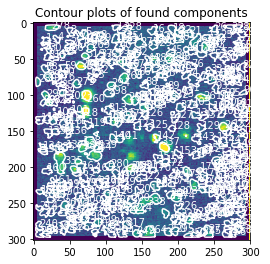

In [16]:
#%% plot contours of found components
Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0
plt.figure(); crd = plot_contours(cnm.A, Cn, thr=0.9)
plt.title('Contour plots of found components')

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="../../docs/img/evaluationcomponent.png"/>

In [17]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, SNR_comp, r_values, cnn_preds = \
    estimate_components_quality_auto(images, cnm.A, cnm.C, cnm.b, cnm.f, 
                                     cnm.YrA, fr, decay_time, gSig, dims, 
                                     dview = dview, min_SNR=min_SNR, 
                                     r_values_min = rval_thr, use_cnn = False, 
                                     thresh_cnn_lowest = cnn_thr)

EVALUATING IN PARALLEL... NOT RETURNING ERFCs


Plot contours of selected and rejected components

/home/murthyhacker/CaImAn/caiman/utils/visualization.py:901: UserWarning: The way to call utilities.plot_contours has changed. Look at the definition for more details.
  "Look at the definition for more details.")


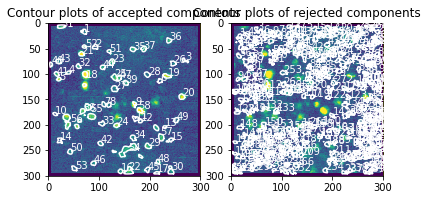

In [18]:
#%% PLOT COMPONENTS

plt.figure();
plt.subplot(121); crd_good = cm.utils.visualization.plot_contours(cnm.A[:,idx_components], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of accepted components')
plt.subplot(122); crd_bad = cm.utils.visualization.plot_contours(cnm.A[:,idx_components_bad], Cn, thr=.8, vmax=0.75)
plt.title('Contour plots of rejected components')

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [19]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons =Cn,
                denoised_color = 'red');

#np.set_printoptions(threshold=np.nan)




           1           2           3           4           5           6    \
1    34.868436   81.430939   40.821842   56.943282   12.990957   23.099184   
2     7.590066   32.233232    0.000000    0.000000   41.714242    0.000000   
3     0.000000    0.000000    0.000000    0.000000    5.300170    0.000000   
4    45.629917   16.180080   20.102697   30.591205    2.928344    0.000000   
5     0.000000   27.055702    6.982829   47.326579   55.288780   16.162801   
6    12.471127    4.536942   15.697715   10.754501    0.000000   16.830944   
7    35.303226   45.080358   29.932639   13.762199   25.077341   15.441331   
8     0.117453   44.518296   22.182557   11.047863   59.272100   42.746562   
9    92.692284   61.492687   98.894073   75.927648   89.768251   62.518852   
10    5.759545    0.000000   19.658866   24.524339    0.000000    1.214148   
11    2.256002    0.000000    8.527025   31.817374   14.482706   29.872815   
12    0.000000   25.125817    0.000000   17.739630    0.000000  

In [20]:
# rejected components
if len(idx_components_bad) > 0:
    nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                    cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons =Cn,
                    denoised_color = 'red');
else:
    print("No components were rejected.")

           1          2           3           4          5          6    \
1    23.470313  22.717721   25.163941    3.112423  23.146601   9.179080   
2    14.681027   4.540921    0.000000   10.412858   0.320827  19.216744   
3    34.617779  24.976825   25.057331   33.339741  26.091666  16.376355   
4    34.412232  18.043065    8.946247   13.222353   0.000000   0.718794   
5    28.602195  24.785950   14.157562    8.566047  35.459233  22.476166   
6    58.672790  43.576708   69.077695  108.648622  74.579950  76.956692   
7    14.021802   0.000000   31.761153   36.561275  13.356812  11.231847   
8    15.117355  43.537489   19.952418    4.174128  49.574096  65.417212   
9    12.265224   0.000000    6.204044    3.676213  12.301209   0.000000   
10    9.087434   5.354201   25.787459    6.393152  25.876770   9.326857   
11    2.123647  51.233905   40.454406    2.248585   0.000000  29.238590   
12   47.223521  33.963234   28.146360   37.633526   8.156998  53.550613   
13   15.163386  25.871636

## Re-run (seeded) CNMF  on the full Field of View  

In [21]:
%%capture
#%% RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution 
A_in, C_in, b_in, f_in = cnm.A[:,idx_components], cnm.C[idx_components], cnm.b, cnm.f
cnm2 = cnmf.CNMF(n_processes=1, k=A_in.shape[-1], gSig=gSig, p=p, dview=dview,
                merge_thresh=merge_thresh,  Ain=A_in, Cin=C_in, b_in = b_in,
                f_in=f_in, rf = None, stride = None, gnb = gnb, 
                method_deconvolution='oasis', check_nan = True)

cnm2 = cnm2.fit(images)

### Extract DF/F values

In [22]:
#%% Extract DF/F values

F_dff = detrend_df_f(cnm2.A, cnm2.b, cnm2.C, cnm2.f, YrA = cnm2.YrA, 
                      quantileMin=8, frames_window=250)



         1         2         3         4         5         6         7    \
1   0.254136  0.480281  0.301685  0.396356  0.141234  0.193716  0.302406   
2  -0.122327 -0.058999 -0.225324 -0.261947 -0.081754 -0.230978 -0.048870   
3   0.034256  0.015287 -0.015066 -0.117660  0.186330 -0.094287  0.129971   
4   0.450489  0.155340  0.289348  0.436788  0.019956 -0.080668  0.260414   
5  -0.011505  0.293787  0.082481  0.409461  0.449122  0.110435 -0.075956   
6  -0.079414 -0.069522  0.023936 -0.027438 -0.105799  0.049868  0.111177   
7   0.139162  0.243124  0.176262 -0.047760  0.070613  0.009177  0.019156   
8  -0.034092  0.168482  0.190149  0.070244  0.317339  0.174891  0.237749   
9   0.247731  0.260784  0.290747  0.205200  0.303052  0.176288  0.223609   
10 -0.015581 -0.295604  0.246758  1.034225 -0.113612 -0.133664  0.115388   
11 -0.047542 -0.231167  0.017972  0.161138  0.039017  0.146182  0.031333   
12 -0.107772  0.042384  0.001252  0.042249 -0.136304  0.009158 -0.042654   
13  0.256272

## Display final results

In [23]:
discard_traces_fluo=nb_view_patches(Yr,cnm2.A, cnm2.C, cnm2.b, cnm2.f,
                                    dims[0], dims[1], thr = 0.8, image_neurons=Cn,
                                    denoised_color='red')
print('you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10')

#from bokeh.plotting import figure
#from bokeh.io import show
#plt.figure();

#plt.imshow(np.reshape(cnm2.A[:,5-1].toarray(), dims, order='F'))

#plt.figure()

#plt.plot(F_dff[5-1][1:100])


           1           2           3           4           5           6    \
1    45.806786   70.017475   62.970440   56.750439   51.260399   46.414661   
2    15.189625   15.189625   15.189625   15.189625   15.189625   15.189625   
3    11.368290   11.368290   11.368290   11.368290   11.368290   11.368290   
4    27.367782   25.288016   23.403850   21.696888   20.150463   18.749476   
5     2.350622   16.693960   15.409826   14.240660   13.176166   12.206974   
6     9.596062    9.596062    9.596062    9.596062    9.596062    9.596062   
7    14.145235   14.083257   14.026806   13.975390   13.928558   13.885903   
8     9.275442   16.191107   15.515710   14.906274   21.368878   20.187811   
9    96.205216  100.966623  101.025176   92.152104   97.349750   88.746583   
10    6.543335    6.543335    6.543335   12.956311   10.799272    9.367765   
11   11.580247   11.580247   11.580247   11.580247   11.580247   11.580247   
12   15.547623   15.547623   15.547623   15.547623   15.547623  

you will may be need to change the data rate to generate this one: use jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10


<h1> closing, saving, and creating denoised version </h1>

In [20]:
save_results = False
if save_results:
    np.savez(os.path.join(os.path.split(fname_new)[0], 
                          os.path.split(fname_new)[1][:-4] + 'results_analysis.npz'),
             Cn=Cn, A=cnm2.A.todense(), C=cnm2.C,
             b=cnm2.b, f=cnm2.f, YrA=cnm2.YrA, sn=sn, d1=d1, d2=d2,
             idx_components=idx_components, idx_components_bad=idx_components_bad)

## stop cluster and clean up LOG files

In [21]:
#%% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)
log_files = glob.glob('*_LOG_*')
for log_file in log_files:
    os.remove(log_file)

We can inspect the denoised results by reconstructing the movie and playing alongside the original

In [22]:
#%% reconstruct denoised movie
denoised = cm.movie(cnm2.A.dot(cnm2.C) + \
                    cnm2.b.dot(cnm2.f)).reshape(dims + (-1,), order='F').transpose([2, 0, 1])

reshaping along z
reshaping along z


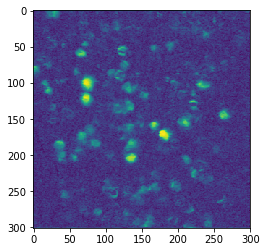

In [38]:
#%% play along side original data
cm.concatenate([m_els.resize(1, 1, downsample_ratio),
                denoised.resize(1, 1, downsample_ratio)], 
                axis=2).play(fr=8, gain=15, magnification=2, offset=0)  # press q to exit
c_img = m_orig.local_correlations(eight_neighbours = True, swap_dim = False) #correlation image
pl.imshow(c_img)